# 4. Stochastic Volatility (SV)

This section implements a 3001-dimensional stochastic volatility model fit to 3000 days of returns from the S&P 500 index. 

Because the scale parameters $s_i$ and the degrees of freedom $\nu$ are constrained to be positive, we apply the change of variables $x_i = \log s_i$ and $\alpha = \log \nu$. The log-posterior includes the necessary Jacobian adjustments for these transformations to maintain the correct target density for NUTS and HMC to sample from.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

from bml.samplers import nuts, hmc
from bml.distributions.sv import StochasticVolatility
from bml.distributions.counter import GradCounter
from bml import metrics

In [ ]:
sp500 = yf.download('^GSPC', start='1995-01-01', end='2010-01-01', progress=True, auto_adjust=False)

# Daily log returns
prices = sp500['Adj Close'].values.flatten()
returns = np.diff(np.log(prices))

# Last 3000 days
R = returns[-3000:]

N_days = len(R) # 3000
d = N_days + 1  # 3001 parameters

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Initial guess
theta0 = np.zeros(d)
theta0[:-1] = np.log(np.std(R)) 
theta0[-1] = np.log(10.0)

# Reduced iterations due to the extreme dimensionality
M = 500             
M_adapt = 250       
delta = 0.65         

# Stochastic Volatility
sv = StochasticVolatility(R)

print(f"Starting Dual Averaging NUTS sampling for {d}-d Stochastic Volatility...")
sampler = nuts.DualAveragingNUTS(L=sv.log_p, grad=sv.grad_log_p)
samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
print(f"Finished sampling with NUTS. Output shape: {samples.shape}")

valid_samples = samples[M_adapt:]

# Calculate ESS for the degrees of freedom parameter (alpha / nu)
alpha_samples = valid_samples[:, -1]
nu_samples = np.exp(alpha_samples)

nu_mu = np.mean(nu_samples)
nu_var = np.var(nu_samples)
ess_nu = metrics.compute_ess_1d(nu_samples, nu_mu, nu_var)
print(f"Effective Sample Size (ESS) for the Degrees of Freedom parameter (nu): {ess_nu:.4f}")

Starting Dual Averaging NUTS sampling for 3001-d Stochastic Volatility...
Finished sampling with NUTS. Output shape: (501, 3001)
Effective Sample Size (ESS) for the Degrees of Freedom parameter (nu): 5.7758


In [ ]:
deltas = np.linspace(0.25, 0.95, 15)
results_delta = []

for delta in deltas:
    print(f"Sampling for Delta={delta:.2f}...")

    model = GradCounter(sv)
    sampler = nuts.DualAveragingNUTS(L=model.log_p, grad=model.grad)

    samples, stats = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
    
    valid_samples = samples[M_adapt:]
    
    # Calculate ESS specifically for the degrees of freedom parameter (nu)
    alpha_samples = valid_samples[:, -1]
    nu_samples = np.exp(alpha_samples)

    nu_mu = np.mean(nu_samples)
    nu_var = np.var(nu_samples)
    ess_nu_mean = metrics.compute_ess_1d(nu_samples, nu_mu, nu_var)
    
    moment_samples = (nu_samples - nu_mu)**2
    moment_mu = np.mean(moment_samples)
    moment_var = np.var(moment_samples)
    ess_nu_var = metrics.compute_ess_1d(moment_samples, moment_mu, moment_var)
    
    min_ess = min(ess_nu_mean, ess_nu_var)

    total_gradients = model.count
    ess_per_gradient = min_ess / total_gradients
    results_delta.append((delta, min_ess, total_gradients, ess_per_gradient))
    print(f"Delta: {delta:.2f}, nu ESS: {min_ess:.4f}, Total Gradients: {total_gradients}, ESS/Gradient: {ess_per_gradient:.6f}\n")

results_df = pd.DataFrame(results_delta, columns=["Delta", "nu ESS", "Total Gradients", "ESS per Gradient"])
results_df.to_csv("../results/SV/DANUTS_delta.csv", index=False)

Sampling for Delta=0.25...
Delta: 0.25, nu ESS: 19.5915, Total Gradients: 220342, ESS/Gradient: 0.000089

Sampling for Delta=0.30...
Delta: 0.30, nu ESS: 7.2708, Total Gradients: 223206, ESS/Gradient: 0.000033

Sampling for Delta=0.35...
Delta: 0.35, nu ESS: 16.7987, Total Gradients: 239952, ESS/Gradient: 0.000070

Sampling for Delta=0.40...
Delta: 0.40, nu ESS: 4.6445, Total Gradients: 238156, ESS/Gradient: 0.000020

Sampling for Delta=0.45...
Delta: 0.45, nu ESS: 5.8463, Total Gradients: 213962, ESS/Gradient: 0.000027

Sampling for Delta=0.50...
Delta: 0.50, nu ESS: 3.6441, Total Gradients: 238160, ESS/Gradient: 0.000015

Sampling for Delta=0.55...
Delta: 0.55, nu ESS: 8.9692, Total Gradients: 223968, ESS/Gradient: 0.000040

Sampling for Delta=0.60...
Delta: 0.60, nu ESS: 5.2122, Total Gradients: 216876, ESS/Gradient: 0.000024

Sampling for Delta=0.65...
Delta: 0.65, nu ESS: 5.1967, Total Gradients: 253462, ESS/Gradient: 0.000021

Sampling for Delta=0.70...
Delta: 0.70, nu ESS: 4.547

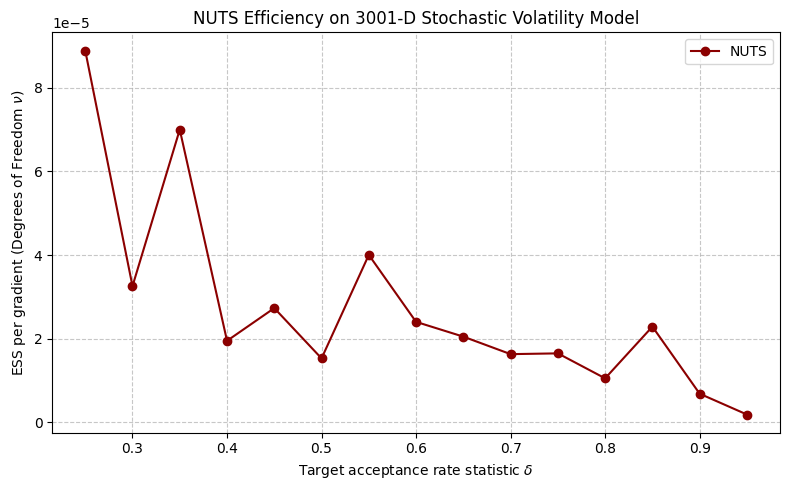

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Delta"], results_df["ESS per Gradient"], marker='o', linestyle='-', color='darkred', label='NUTS')

# We omit HMC here as its fixed trajectory calculation makes it prohibitively slow for 3001-d
plt.xlabel('Target acceptance rate statistic $\\delta$')
plt.ylabel('ESS per gradient (Degrees of Freedom $\\nu$)')
plt.title('NUTS Efficiency on 3001-D Stochastic Volatility Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.savefig("../results/SV/SV_efficiency_plot.png")
plt.show()